In [1]:
# import the needed packages and check version
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("tensorflow: ", tf.__version__) #2.0.0
print("tensorflow_prob: ", tfp.__version__) #

tensorflow:  2.0.0
tensorflow_prob:  0.8.0


In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [3]:
#import the fashion mnist dataset (from Zalando)
fashion_mnist = keras.datasets.fashion_mnist
data = fashion_mnist.load_data()
(train_images, train_labels), (test_images, test_labels) = data
#(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [5]:
#preprocess the data
train_x = np.expand_dims(train_images/255.0, axis=3)
train_y = train_labels
test_y = test_labels
test_x = np.expand_dims(test_images/255.0, axis=3)

## prepare data and exclude one class

exclude one class and get this class seperately from the test set to test later

In [6]:
nine_x = test_x[np.where(test_y==9)[0]]
nine_y = test_y[np.where(test_y==9)[0]]

zero_x = test_x[np.where(test_y==0)[0]]
zero_y = test_y[np.where(test_y==0)[0]]

In [7]:
train_x = np.delete(train_x, np.where((train_y==9))[0], axis = 0)
train_y = np.delete(train_y, np.where(train_y==9)[0], axis = 0)

In [8]:
train_y = np.array(pd.get_dummies(train_y))

In [9]:
test_x_reduced = np.delete(test_x, np.where((test_y==9))[0], axis=0)
test_y_reduced = np.delete(test_y, np.where((test_y==9))[0], axis=0)

In [10]:
test_y_reduced = np.array(pd.get_dummies(test_y_reduced))

In [11]:
#adjust labels
class_names_adj = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag']

## construct a baseline CNN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 9)                 2

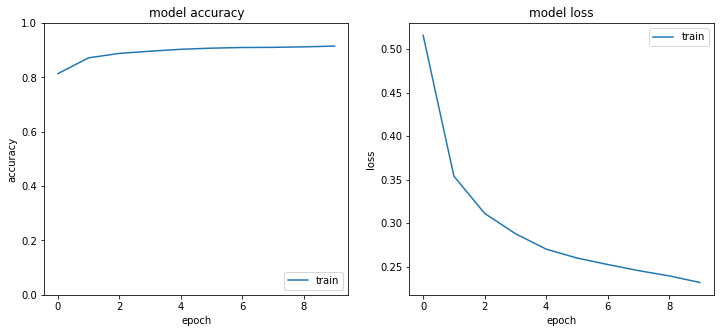

In [43]:
# Construct a baseline CNN

model_b = keras.Sequential([
    keras.layers.Convolution2D(8, kernel_size=(3,3), padding="same", activation='relu', input_shape=(28,28,1)),
    keras.layers.Convolution2D(8, kernel_size=(3,3), padding="same", activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Convolution2D(16, kernel_size=(3,3), padding="same", activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dropout((0.5)),
    keras.layers.Dense(9, activation='softmax')
])

model_b.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_b.summary()

history_b = model_b.fit(train_x, train_y, epochs = 10)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_b.history['acc'])
#plt.plot(history_b.history['val_accuracy'])
plt.ylim(0,1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(history_b.history['loss'])
#plt.plot(history_b.history['va_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [44]:
model_b.evaluate(test_x_reduced, test_y_reduced) #test the network with adjusted test set

9000/9000 [==============================] - 2s 202us/sample - loss: 0.2431 - acc: 0.9123


[0.24310792985227372, 0.9123333]

In [45]:
model_b.save('A_008_model_b.h5') #save the model

In [12]:
model_b = tf.keras.models.load_model('A_model_b.h5')

W1206 10:53:18.711289 10544 deprecation.py:506] From C:\Users\annar\Anaconda3\envs\ml_env\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## create a BNN with variational inference

In [13]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (train_x.shape[0] *1.0)

In [14]:
model_vi = keras.Sequential([
    tfp.layers.Convolution2DFlipout(8, kernel_size=(3,3), padding="same", activation='relu', 
                                    kernel_divergence_fn=kernel_divergence_fn, input_shape=(28,28,1)),
    tfp.layers.Convolution2DFlipout(8, kernel_size=(3,3), padding="same", activation='relu', 
                                    kernel_divergence_fn = kernel_divergence_fn),
    keras.layers.MaxPooling2D(2,2),
    tfp.layers.Convolution2DFlipout(16, kernel_size=(3,3), padding="same", activation='relu', 
                                    kernel_divergence_fn=kernel_divergence_fn),
    keras.layers.Flatten(),
    #keras.layers.Dropout((0.5)),
    tfp.layers.DenseFlipout(9, activation='softmax', kernel_divergence_fn=kernel_divergence_fn)
])

model_vi.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model_vi.summary()

W1206 10:53:42.022192 10544 deprecation.py:323] From C:\Users\annar\Anaconda3\envs\ml_env\lib\site-packages\tensorflow_probability\python\layers\util.py:104: Layer.add_variable (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.add_weight` method instead.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 28, 28, 8)         152       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 28, 28, 8)         1160      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_flipout_2 (Conv2DFlip (None, 14, 14, 16)        2320      
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_flipout (DenseFlipout) (None, 9)                 56457     
Total params: 60,089
Trainable params: 60,089
Non-trainable params: 0
____________________________________________________

For each prediction now we get different probabilities

In [15]:
for i in range(0,5):
  print(model_vi.predict(train_x[0:1])[0])

[0.09069002 0.07989125 0.09356403 0.09162315 0.12571064 0.17126374
 0.09960321 0.0687487  0.17890528]
[0.05335067 0.22470267 0.07368556 0.10185979 0.12203061 0.1280392
 0.08713818 0.07857859 0.13061482]
[0.06124888 0.15520921 0.12537321 0.14881317 0.10008454 0.08525317
 0.08714456 0.0731087  0.16376455]
[0.05532826 0.11979251 0.1412098  0.12389272 0.13372101 0.09785076
 0.09617206 0.05600041 0.17603242]
[0.10920502 0.06710151 0.14360172 0.11849762 0.10924949 0.10673697
 0.0921937  0.09815041 0.1552635 ]


In [20]:
history_vi = model_vi.fit(train_x, train_y, epochs = 10)

Train on 54000 samples
Epoch 1/10
54000/54000 [==============================] - 127s 2ms/sample - loss: 1.9161 - accuracy: 0.7784
Epoch 2/10
54000/54000 [==============================] - 128s 2ms/sample - loss: 1.5021 - accuracy: 0.8645
Epoch 3/10
54000/54000 [==============================] - 119s 2ms/sample - loss: 1.3151 - accuracy: 0.8792
Epoch 4/10
54000/54000 [==============================] - 120s 2ms/sample - loss: 1.1858 - accuracy: 0.8885
Epoch 5/10
54000/54000 [==============================] - 116s 2ms/sample - loss: 1.0855 - accuracy: 0.8963
Epoch 6/10
54000/54000 [==============================] - 118s 2ms/sample - loss: 1.0065 - accuracy: 0.8999
Epoch 7/10
54000/54000 [==============================] - 121s 2ms/sample - loss: 0.9395 - accuracy: 0.9046
Epoch 8/10
54000/54000 [==============================] - 110s 2ms/sample - loss: 0.8819 - accuracy: 0.9075
Epoch 9/10
54000/54000 [==============================] - 109s 2ms/sample - loss: 0.8381 - accuracy: 0.9090
Epoch

In [16]:
model_vi.evaluate(test_x_reduced, test_y_reduced) #test the network with adjusted test set

9000/9000 [==============================] - 8s 920us/sample - loss: 3.6582 - accuracy: 0.1019


[3.658216415829129, 0.10188889]

In [24]:
model_vi.save('A_010_model_vi.h5') #save the model

In [17]:
model_vi.load_weights('A_010_model_vi.h5')

## test with a picture from a class the network has seen before

In [18]:
# set picture
picture = 100
picture_end = picture+1

In [19]:
model_vi.predict(zero_x[picture:picture_end])[0]

array([7.0457202e-01, 6.3970743e-04, 1.8060855e-03, 1.7885707e-01,
       1.7118450e-02, 3.4566622e-10, 9.6965641e-02, 1.4508088e-08,
       4.1050469e-05], dtype=float32)

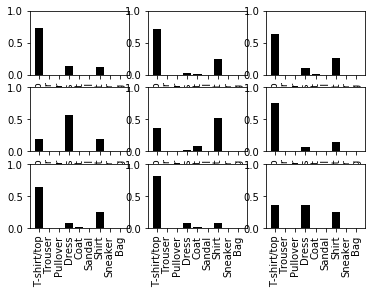

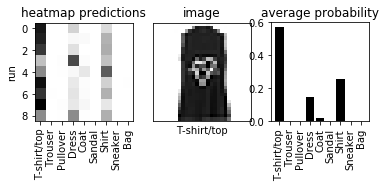

[5.7220423e-01 8.2328456e-04 3.2160019e-03 1.4499281e-01 1.7195614e-02
 5.4942393e-07 2.5859714e-01 4.0235049e-05 2.9301376e-03]


In [20]:
x = [0,1,2,3,4,5,6,7,8]
predictions = model_vi.predict(zero_x[picture:picture_end])
for i in range(100):
    pred = model_vi.predict(zero_x[picture:picture_end])
    predictions = np.append(predictions, pred, axis = 0)
    
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.bar(x, predictions[i], color = ['black'])
    plt.xticks(np.arange(9), class_names_adj, rotation = 90)
    #plt.yticks([0.25, 0.5, 0.75, 1.0])
    plt.ylim([0,1])
plt.show()
    #print(i, predictions)
#x = [1,2,3,4,5,6,7,8,9]
#y = pred[0].tolist()
#plt.bar(x, y)
#print(predictions)
plt.subplot(2,3,1)
plt.yticks([0,2,4,6,8])
plt.imshow(predictions[0:9], cmap='binary', interpolation='none')
plt.ylabel('run')
#plt.xlabel('class')
plt.xticks(np.arange(9), class_names_adj, rotation = 90)
plt.title('heatmap predictions')
plt.subplot(2,3,2)
plt.xticks([])
plt.yticks([])
plt.imshow(np.squeeze(zero_x[picture:picture_end][0], axis = 2), cmap=plt.cm.binary)
plt.xlabel(class_names_adj[zero_y[picture_end]])
plt.title('image')

#### try to also show the barchart with the average probability
d = predictions
predictions_mean = d.mean(axis=0)
x = [0,1,2,3,4,5,6,7,8]

plt.subplot(2,3,3)
plt.bar(x,predictions_mean, color = ['black']) #color=(0.3,0.3,0.3,1.0)
plt.xticks(np.arange(9), class_names_adj, rotation = 90)
plt.title('average probability')

plt.show()
print(predictions_mean)

## test with a picture from a class the network has not seen before

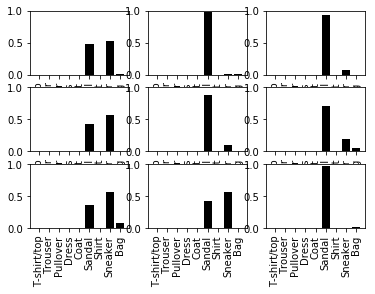

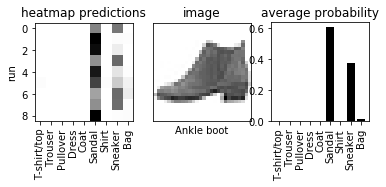

[3.1794122e-04 8.1372214e-05 7.6031442e-06 1.2128303e-05 3.2129668e-05
 6.0592437e-01 8.8398444e-04 3.7760895e-01 1.5131481e-02]


In [21]:
x = [0,1,2,3,4,5,6,7,8]
predictions = model_vi.predict(nine_x[picture:picture_end])
for i in range(100):
    pred = model_vi.predict(nine_x[picture:picture_end])
    predictions = np.append(predictions, pred, axis = 0)
    
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.bar(x, predictions[i], color = ['black'])
    plt.xticks(np.arange(9), class_names_adj, rotation = 90)
    #plt.yticks([0.25, 0.5, 0.75, 1.0])
    plt.ylim([0,1])
plt.show()
    #print(i, predictions)
#x = [1,2,3,4,5,6,7,8,9]
#y = pred[0].tolist()
#plt.bar(x, y)
#print(predictions)
plt.subplot(2,3,1)
plt.yticks([0,2,4,6,8])
plt.imshow(predictions[0:9], cmap='binary', interpolation='none')
plt.ylabel('run')
#plt.xlabel('class')
plt.xticks(np.arange(9), class_names_adj, rotation = 90)
plt.title('heatmap predictions')
plt.subplot(2,3,2)
plt.xticks([])
plt.yticks([])
plt.imshow(np.squeeze(nine_x[picture:picture_end][0], axis = 2), cmap=plt.cm.binary)
plt.xlabel(class_names[nine_y[picture_end]])
plt.title('image')

#### try to also show the barchart with the average probability
d = predictions
predictions_mean = d.mean(axis=0)
x = [0,1,2,3,4,5,6,7,8]

plt.subplot(2,3,3)
plt.bar(x,predictions_mean, color = ['black']) #color=(0.3,0.3,0.3,1.0)
plt.xticks(np.arange(9), class_names_adj, rotation = 90)
plt.title('average probability')

plt.show()
print(predictions_mean)

# Compare the two networks with each other

In [35]:
#first on the reduced test set, where the class 9 has been deleted
model_b.evaluate(test_x_reduced, test_y_reduced)

9000/9000 [==============================] - 4s 408us/sample - loss: 2.3807 - accuracy: 0.2186


[2.3806834466722275, 0.21855555]

In [36]:
model_vi.evaluate(test_x_reduced, test_y_reduced)

9000/9000 [==============================] - 8s 922us/sample - loss: 0.8399 - accuracy: 0.8917


[0.8398836990462409, 0.89166665]

# Check and quantify BNN

In [22]:
#import the helper functions for evaluation
from helper_functions import m_predict_vi as apvi 
from helper_functions import b_predict_vi as bpvi

## Bernoulli predict

In [23]:
list_of_predictions = [5, 10, 25, 50, 100]
list_of_dev = [0.1, 0.2, 0.3, 0.4, 0.5]

In [24]:
pred = bpvi.bern_predict_vi(test_x, model_vi, 9, 5)

In [19]:
#import pandas as pd
p = pd.DataFrame(pred)
p['soll'] = test_y
#p.to_csv("A_010_test_set_with_predictions_25.csv", ";")

In [20]:
#just the predictions:
(p[0] == test_y).sum()/test_x.shape[0]

0.8139

In [21]:
#for different uncertainty levels
for i in list_of_dev:
    p['unc_est'] = np.where(p[3] >= i, 9, p[0])
    w = (p['unc_est'] == test_y).sum()/test_x.shape[0]
    print(i, ": " , w)

0.1 :  0.7304
0.2 :  0.7304
0.3 :  0.7711
0.4 :  0.7863
0.5 :  0.8109


In [93]:
#import pandas as pd
#p = pd.read_csv("A_008_test_set_with_predictions_100.csv", sep=';')

In [22]:
#evaluate with ranges
for i in list_of_dev:
    for j in list_of_dev:
        if j>i:
                p['unc_est'] = np.where(((p[3] >= i) & (p[3]<=j)), 9, p[0])
                w = (p['unc_est'] == test_y).sum()/test_x.shape[0]
                print(i, "-", j, ": " , w)
            

0.1 - 0.2 :  0.788
0.1 - 0.3 :  0.7732
0.1 - 0.4 :  0.7519
0.1 - 0.5 :  0.7304
0.2 - 0.3 :  0.7732
0.2 - 0.4 :  0.7519
0.2 - 0.5 :  0.7304
0.3 - 0.4 :  0.7926
0.3 - 0.5 :  0.7711
0.4 - 0.5 :  0.7863


### plot the results

In [24]:
x = [5, 10, 25]
y = [0.8116, 0.8109, 0.8139]
y50 = [0.8116, 0.8094, 0.8109]
y40 = [0.7703, 0.7776, 0.7863]
y30 = [0.7703, 0.7535, 0.7711]
y20 = [0.7703, 0.7535, 0.7304]
y10 = [0.7703, 0.7535, 0.7304]

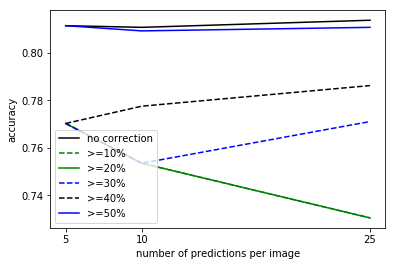

In [26]:
import matplotlib.pyplot as plt

plt.plot(x, y, label='no correction', color='black')
plt.plot(x, y10, label='>=10%', color='green', linestyle='--')
plt.plot(x, y20, label='>=20%', color='green', linestyle='-')
plt.plot(x, y30, label='>=30%', color='blue', linestyle='--')
plt.plot(x, y40, label='>=40%', color='black', linestyle='--')
plt.plot(x, y50, label='>=50%', color='blue', linestyle='-')

plt.xlabel('number of predictions per image')
plt.ylabel('accuracy')
plt.xticks(x)
#plt.yticks(list_of_dev)

plt.legend(loc='lower left')
plt.show()

## Average predict

In [ ]:
pred = apvi.average_predict_vi(test_x, model_vi, 9, 25)

In [46]:
df = pd.DataFrame(pred)
df['soll'] = test_y
df.to_csv("A_010_test_with_max_pred_25.csv", ";")

C:\Users\annar\Anaconda3\envs\ml_env\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  


In [47]:
#just the predictions:
(df[0] == test_y).sum()/test_x.shape[0]

0.8149

In [48]:
#for different uncertainty levels
for i in list_of_dev:
    df['unc_est'] = np.where(df[3] >= i, 9, df[0])
    w = (df['unc_est'] == test_y).sum()/test_x.shape[0]
    print(i, ": " , w)

0.1 :  0.6949
0.2 :  0.8156
0.3 :  0.8362
0.4 :  0.8167
0.5 :  0.8149


In [49]:
#evaluate with ranges
for i in list_of_dev:
    for j in list_of_dev:
        if j>i:
                df['unc_est'] = np.where(((df[3] >= i) & (df[3]<=j)), 9, df[0])
                w = (df['unc_est'] == test_y).sum()/test_x.shape[0]                
                print(i, "-", j, ": " , w)
            

0.1 - 0.2 :  0.6942
0.1 - 0.3 :  0.6736
0.1 - 0.4 :  0.6931
0.1 - 0.5 :  0.6949
0.2 - 0.3 :  0.7943
0.2 - 0.4 :  0.8138
0.2 - 0.5 :  0.8156
0.3 - 0.4 :  0.8344
0.3 - 0.5 :  0.8362
0.4 - 0.5 :  0.8167


### graphic

In [50]:
x = [5, 10, 25]
y = [0.8122, 0.8129, 0.8149]
y50 = [0.8124, 0.8129, 0.8149]
y40 = [0.82, 0.8171, 0.8167]
y30 = [0.8245, 0.8337, 0.8362]
y20 = [0.7989, 0.8092, 0.8156]
y10 = [0.7154, 0.7038, 0.6949]

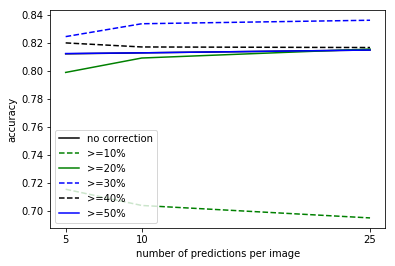

In [51]:
import matplotlib.pyplot as plt

plt.plot(x,y, label='no correction', color='black')
plt.plot(x, y10, label='>=10%', color='green', linestyle='--')
plt.plot(x, y20, label='>=20%', color='green', linestyle='-')
plt.plot(x, y30, label='>=30%', color='blue', linestyle='--')
plt.plot(x, y40, label='>=40%', color='black', linestyle='--')
plt.plot(x, y50, label='>=50%', color='blue', linestyle='-')

plt.xlabel('number of predictions per image')
plt.ylabel('accuracy')
plt.xticks(x)
#plt.yticks(list_of_dev)

plt.legend(loc='lower left')
plt.show()